In [ ]:
!pip install mesa==3.0.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.5/226.5 kB 5.1 MB/s eta 0:00:00


<ipython-input-7-4dc4d0d0561f>:208: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = SimultaneousActivation(self)
<ipython-input-7-4dc4d0d0561f>:432: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()  # Adjust layout for readability


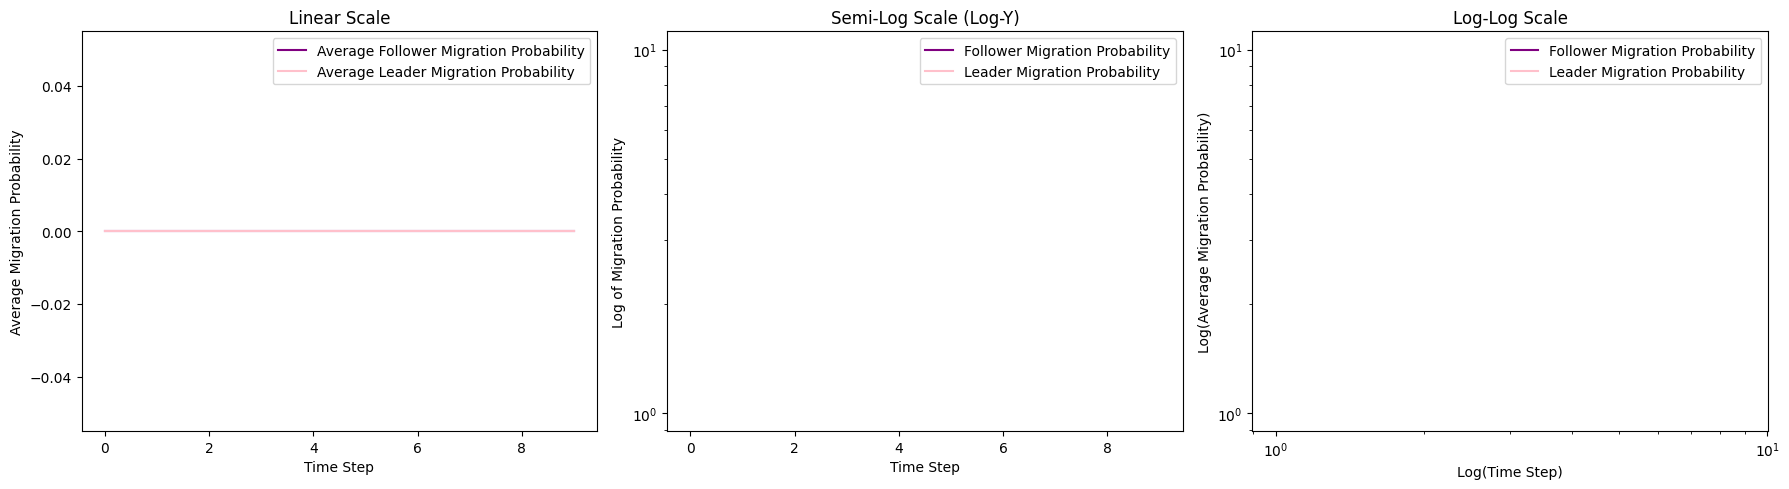

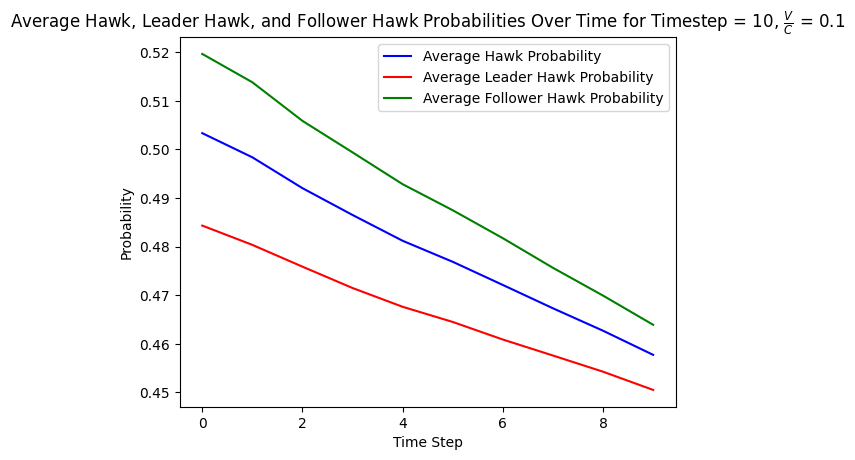

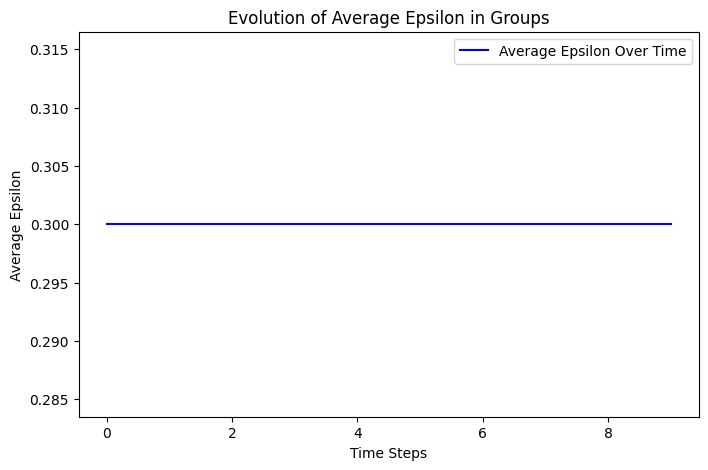

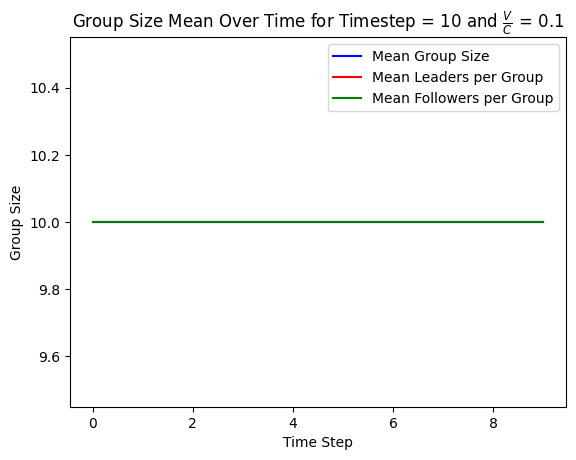

<ipython-input-7-4dc4d0d0561f>:474: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmapl = cm.get_cmap('tab20', len(sorted_leader_sizes))
<ipython-input-7-4dc4d0d0561f>:476: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmapf = cm.get_cmap('tab20', len(sorted_follower_sizes))


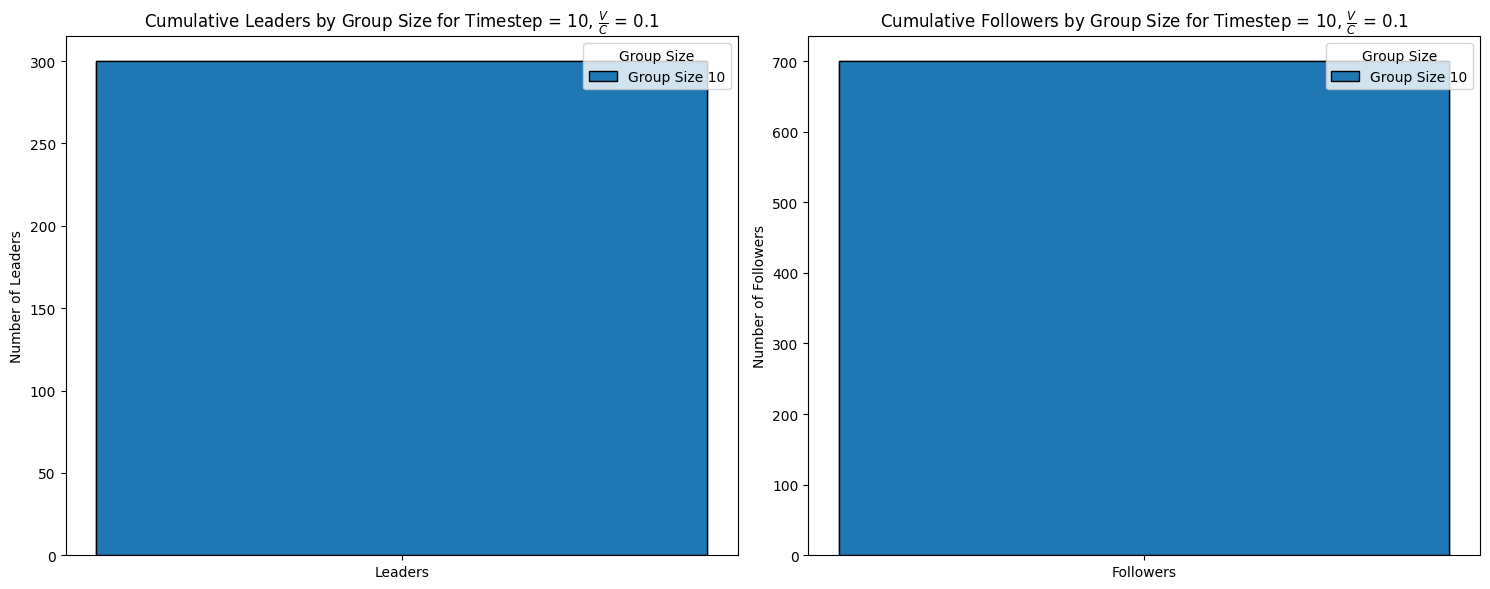

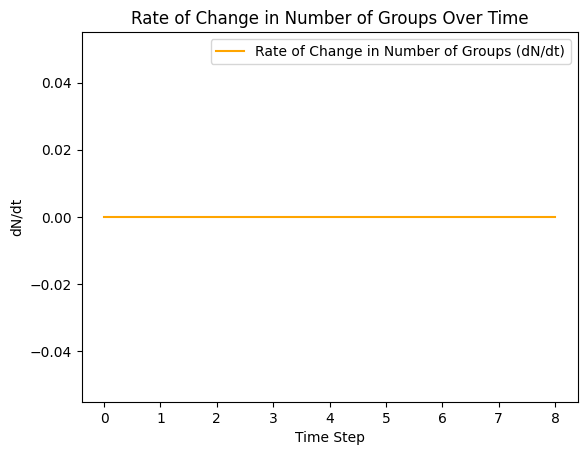

Estimated N_max: 100.00
Estimated N_0: 100.00
Estimated r: 0.83


<ipython-input-7-4dc4d0d0561f>:570: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(logistic, t_data, N_data, p0=[15, 2, 0.5])


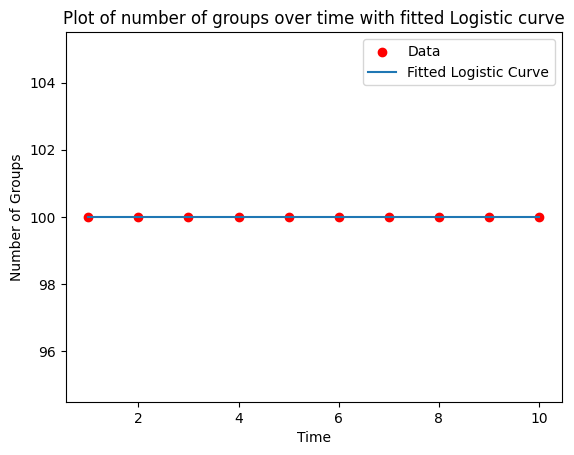

In [ ]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from scipy import stats
from scipy.optimize import curve_fit

class IndividualAgent(Agent):
    def __init__(self, unique_id, model, group_id, role, dv, dc, V, C):
        super().__init__(model)
        self.group_id = group_id
        self.role = role  # 'leader' or 'follower'
        self.leader_hawk_prob = random.uniform(0, 1) if role == 'leader' else None
        self.follower_hawk_prob = random.uniform(0, 1) if role == 'follower' else None
        self.dv = dv
        self.dc = dc
        self.V = V
        self.C = C
        self.fisfus_prob = 0 #random.uniform(0, 1) if role == 'follower' else None  # Probability for followers to switch groups
        self.leader_fisfus_prob = 0 #random.uniform(0, 1) if role == 'leader' else None  # Probability for leaders to switch groups

class Group:
    def __init__(self, group_id, agents, model, omega, dv, dc, V, C):
        self.group_id = group_id
        self.agents = agents
        self.model = model
        self.hawk_prob = self.calculate_hawk_prob()
        self.strategy = self.determine_strategy()
        self.payoff = 0  # Initialize payoff
        self.dv = dv
        self.dc = dc
        self.V = V
        self.C = C

    def calculate_hawk_prob(self):
        # Calculate number of leaders and followers in the group
        num_leader = sum(1 for agent in self.agents if agent.role == "leader")
        num_follower = sum(1 for agent in self.agents if agent.role == "follower")

        # Calculate average follower and leader probability of playing Hawk
        leader_hawk_prob_avg = (
            sum(agent.leader_hawk_prob for agent in self.agents if agent.role == 'leader') / num_leader
            if num_leader > 0 else 0
        )
        follower_hawk_prob_avg = (
            sum(agent.follower_hawk_prob for agent in self.agents if agent.role == 'follower') / num_follower
            if num_follower > 0 else 0
        )

        # Calculate alpha
        epsilon = num_leader / (num_leader + num_follower)
        alpha = epsilon / (epsilon + self.model.omega * (1 - epsilon))

        # Recalculate the overall Hawk probability as a weighted average of leader and follower probabilities
        hawk_prob = (alpha * leader_hawk_prob_avg +
                          (1 - alpha) * follower_hawk_prob_avg)
        return hawk_prob

    def determine_strategy(self):
        return 'Hawk' if self.model.random.random() < self.hawk_prob else 'Dove'

    def calculate_payoff(self, neighbors):
        # Calculate number of leaders and followers in the group
        num_leader = sum(1 for agent in self.agents if agent.role == "leader")
        num_follower = sum(1 for agent in self.agents if agent.role == "follower")
        n = num_leader + num_follower
        epsilon = num_leader / (n)

        # Calculate value and cost values for leaders and followers
        CL = (C * (1 - dc)) / ((n * dc) * (1 - epsilon) + (n * epsilon) * (1 - dc))
        CF = (C * dc) / ((n * dc) * (1 - epsilon) + (n * epsilon) * (1 - dc))
        VL = (V * dv) / ((n * epsilon * dv) + (n * (1 - dv) * (1 - epsilon)))
        VF = (V * (1 - dv)) / ((n * epsilon * dv) + (n * (1 - dv) * (1 - epsilon)))

        # Count the number of agents in neighbors who played Hawk and Dove
        hawk_count = sum(1 for neighbor in neighbors if neighbor.strategy == 'Hawk')
        dove_count = sum(1 for neighbor in neighbors if neighbor.strategy == 'Dove')
        total_agents = len(neighbors)

        # Avoid division by zero in empirical_hawk_prob calculation
        empirical_hawk_prob = hawk_count / total_agents if total_agents > 0 else 0

        # Calculate payoffs for the group based on strategies
        if self.strategy == 'Hawk':
            overall_payoff = ((V - C) / 2) * hawk_count + V * dove_count
            leader_payoff = ((VL - CL) / 2) * hawk_count + VL * dove_count
            follower_payoff = ((VF - CF) / 2) * hawk_count + VF * dove_count
        else:
            overall_payoff = (V / 2) * dove_count
            leader_payoff = (VL / 2) * dove_count
            follower_payoff = (VF / 2) * dove_count

        # Assign the overall payoff to the group
        self.payoff = overall_payoff

        # Output the calculated payoffs
        return {
            'overall_payoff': overall_payoff,
            'leader_payoff': leader_payoff,
            'follower_payoff': follower_payoff,
            'empirical_hawk_prob': empirical_hawk_prob,
            'hawk_count': hawk_count
        }

    def step(self):
        # Find neighbors (other groups)
        neighbors = [agent for group in self.model.groups if group.group_id != self.group_id for agent in group.agents]

        # Calculate the group's payoff
        payoff_data = self.calculate_payoff(neighbors)

    def advance(self):
        total_leader_payoff = 0
        total_follower_payoff = 0
        total_payoff = 0
        hawk_count = 0
        num_other_groups = len(self.model.groups) - 1

        # Calculate number of leaders and followers in the group
        num_leader = sum(1 for agent in self.agents if agent.role == "leader")
        num_follower = sum(1 for agent in self.agents if agent.role == "follower")

        # Calculate alpha
        epsilon = num_leader / (num_leader + num_follower)
        alpha = epsilon / (epsilon + self.model.omega * (1 - epsilon))

        # Loop through all other groups to calculate total payoffs
        for other_group in self.model.groups:
            if other_group != self:  # Exclude current group
                payoffs = other_group.calculate_payoff(self.model.groups)
                total_leader_payoff += payoffs['leader_payoff']
                total_follower_payoff += payoffs['follower_payoff']
                total_payoff += payoffs['overall_payoff']
                hawk_count += sum(1 for agent in other_group.agents if agent.role == 'leader' and other_group.strategy == 'Hawk')

        avg_leader_payoff = total_leader_payoff / (len(self.model.groups) - 1)
        avg_follower_payoff = total_follower_payoff / (len(self.model.groups) - 1)

        # Calculate the current group's payoffs
        current_payoffs = self.calculate_payoff(self.model.groups)
        leader_payoff_diff = current_payoffs['leader_payoff'] - avg_leader_payoff
        follower_payoff_diff = current_payoffs['follower_payoff'] - avg_follower_payoff
        empirical_hawk_prob = current_payoffs['empirical_hawk_prob']

        # Update individual probabilities
        learning_rate = 0.05
        # Update agent probabilities based on group's strategy
        for agent in self.agents:
            if self.strategy == 'Hawk':  # If group played Hawk, increase probability
                if agent.role == 'leader':
                    agent.leader_hawk_prob += learning_rate * alpha * leader_payoff_diff * abs(empirical_hawk_prob - agent.leader_hawk_prob) * (1 - agent.leader_hawk_prob)
                    agent.leader_hawk_prob = max(0, min(1, agent.leader_hawk_prob)) # Ensure probabilities stay in [0,1]
                elif agent.role == 'follower':
                    agent.follower_hawk_prob += learning_rate * (1 - alpha) * follower_payoff_diff * abs(empirical_hawk_prob - agent.follower_hawk_prob) * (1 - agent.follower_hawk_prob)
                    agent.follower_hawk_prob = max(0, min(1, agent.follower_hawk_prob)) # Ensure probabilities stay in [0,1]
            else:  # If group played Dove, decrease probability
                if agent.role == 'leader':
                    agent.leader_hawk_prob -= learning_rate * alpha * leader_payoff_diff * abs(empirical_hawk_prob - agent.leader_hawk_prob) * agent.leader_hawk_prob
                    agent.leader_hawk_prob = max(0, min(1, agent.leader_hawk_prob)) # Ensure probabilities stay in [0,1]
                elif agent.role == 'follower':
                    agent.follower_hawk_prob -= learning_rate * (1 - alpha) * follower_payoff_diff * abs(empirical_hawk_prob - agent.follower_hawk_prob) * agent.follower_hawk_prob
                    agent.follower_hawk_prob = max(0, min(1, agent.follower_hawk_prob)) # Ensure probabilities stay in [0,1]

        # Recalculate the group's Hawk probability and strategy
        self.hawk_prob = self.calculate_hawk_prob()
        self.strategy = self.determine_strategy()

        learning_rate_fisfus = 0.05
        # Update fusion probability for each follower & leader
        for agent in self.agents:
            if agent.role == "follower":
                resource_factor = 1 #- (V / C)  # As V/C increases, resource_factor decreases
                if self.payoff < avg_follower_payoff:  # Group payoff is worse than average then increase fisfus_prob
                    agent.fisfus_prob *= (1 + learning_rate_fisfus * abs(follower_payoff_diff) * agent.fisfus_prob) # * resource_factor)
                    agent.fisfus_prob = min(1, agent.fisfus_prob)
                else:  # Group payoff is better than average then decrease fisfus_prob
                    agent.fisfus_prob /= (1 + learning_rate_fisfus * abs(follower_payoff_diff) * agent.fisfus_prob) # * resource_factor)
                    agent.fisfus_prob = max(0, agent.fisfus_prob)
            else:
                if self.payoff < avg_leader_payoff:  # Group payoff is worse than average then increase fisfus_prob
                    agent.leader_fisfus_prob *= (1 + learning_rate_fisfus * abs(leader_payoff_diff) * agent.leader_fisfus_prob)
                    agent.leader_fisfus_prob = min(1, agent.leader_fisfus_prob)
                else:  # Group payoff is better than average then decrease fisfus_prob
                    agent.leader_fisfus_prob /= (1 + learning_rate_fisfus * abs(leader_payoff_diff) * agent.leader_fisfus_prob)
                    agent.leader_fisfus_prob = max(0, agent.leader_fisfus_prob)


    def get_epsilon(self):   # Method for calculating epsilon for the group
        num_leader = sum(1 for agent in self.agents if agent.role == "leader")
        num_follower = sum(1 for agent in self.agents if agent.role == "follower")
        return num_leader / (num_leader + num_follower) if (num_leader + num_follower) > 0 else 0


class GroupModel(Model):
    def __init__(self, N, num_groups, omega, dv, dc, V, C, time_steps):
        self.num_groups = num_groups
        self.time_steps = time_steps
        self.omega = omega
        self.dv = dv
        self.dc = dc
        self.V = V
        self.C = C
        self.Vbar=V/C
        self.random = random.Random()
        self.schedule = SimultaneousActivation(self)
        self.groups = []
        self.hawk_prob_values = []  # To store average Hawk probabilities over time
        self.leader_hawk_prob_values = []  # To store leader Hawk probabilities over time
        self.follower_hawk_prob_values = []  # To store follower Hawk probabilities over time
        self.fisfus_prob_values = []  # To store average fisfus_prob over time
        self.leader_fisfus_prob_values = [] # To store average leader fisfus_prob over time
        self.median_group_size_values = []  # Store median group size over time
        self.mean_group_size_values = []    # Store mean group size over time
        self.mean_leaders_per_group_values = []
        self.mean_followers_per_group_values = []
        self.mode_group_size_values = []    # Store mode group size over time
        self.num_groups_history = []  # To store the number of groups at each time step
        self.average_epsilon_values = []  # List to store average epsilon per time step


        # Create agents and assign them to groups
        agents_per_group = N // num_groups


        for group_id in range(num_groups):
            agents = []

            # Create leaders
            for i in range(3):
                leader = IndividualAgent(group_id * agents_per_group + i, self, group_id, 'leader', dv, dc, V, C)
                agents.append(leader)

            # Create followers
            for i in range(3, agents_per_group):
                follower = IndividualAgent(group_id * agents_per_group + i, self, group_id, 'follower', dv, dc, V, C)
                agents.append(follower)

            group = Group(group_id, agents, self, omega=omega, dv=dv, dc=dc, V=V, C=C)
            self.groups.append(group)

            for agent in agents:
                self.schedule.add(agent)

    def step(self):
        # Call advance for all groups to update their state
        for group in self.groups:
            group.advance()

        # Handle follower migration
        self.handle_follower_migration()

        # Collect and store probabilities for plotting
        self.collect_probabilities()


        # Track and collect average epsilon over all groups at this time step
        avg_epsilon = np.mean([group.get_epsilon() for group in self.groups])
        self.average_epsilon_values.append(avg_epsilon)

        # Advance the simulation's schedule
        self.schedule.step()

        # Track the number of groups at this time step
        self.num_groups_history.append(len(self.groups))

    def get_final_prob_values(self):
        return {
            "leader_hawk_prob_values": self.leader_hawk_prob_values[-100:],
            "follower_hawk_prob_values": self.follower_hawk_prob_values[-100:],
            "hawk_prob_values": self.hawk_prob_values[-100:]
        }

    def handle_follower_migration(self):
        moving_followers = []  # List of followers who will move
        moving_leaders = [] # List of leaders who will move
        new_groups = [] # List of newly created groups

        num_groups = len(self.groups) # Calculate current number of groups


        # Identify followers who will move
        for group in self.groups:
            for agent in group.agents:
                if agent.role == 'follower' and random.random() < agent.fisfus_prob:
                    moving_followers.append((agent, group))  # Store agent & current group
                if agent.role == 'leader' and random.random() < agent.leader_fisfus_prob:
                  moving_leaders.append((agent, group)) # Store agent & current group

        # Move followers to a random new group or create new group
        for agent, old_group in moving_followers:
                # Determine if the agent will start a new group
                chance_of_new_group = (1 / (num_groups)) # Inversely proportional to the number of groups
                chance_of_new_group = max(0, chance_of_new_group)
                if random.random() < chance_of_new_group:
                    # Create a new group with this agent
                    new_group = self.create_new_group(agent)
                    new_groups.append(new_group)  # Add the new group to the list
                    self.groups.append(new_group)  # Add to the overall group list
                    old_group.agents.remove(agent)  # Remove from old group
                    agent.group_id = new_group.group_id  # Update group ID
                else:
                    # Move to an existing random group
                    new_group = random.choice([g for g in self.groups if g != old_group])  # Pick a different group
                    old_group.agents.remove(agent)  # Remove from old group
                    new_group.agents.append(agent)  # Add to new group
                    agent.group_id = new_group.group_id  # Update group ID

        # Move leaders to a new random group
        for agent, old_group in moving_leaders:
                # Determine if the agent will start a new group
                chance_of_new_group = (1 / (num_groups))  # Inversely proportional to the number of groupsfisfus_prob)  # Inversely proportional to the number of groups
                chance_of_new_group = max(0, chance_of_new_group)
                if random.random() < chance_of_new_group:
                    # Create a new group with this leader
                    new_group = self.create_new_group(agent)
                    new_groups.append(new_group)  # Add the new group to the list
                    self.groups.append(new_group)  # Add to the overall group list
                    old_group.agents.remove(agent)  # Remove from old group
                    agent.group_id = new_group.group_id  # Update group ID
                else:
                    # Move to an existing random group
                    new_group = random.choice([g for g in self.groups if g != old_group])  # Pick a different group
                    old_group.agents.remove(agent)  # Remove from old group
                    new_group.agents.append(agent)  # Add to new group
                    agent.group_id = new_group.group_id  # Update group ID

        self.groups = [group for group in self.groups if group.agents]  # Keep groups that have agents

    def create_new_group(self, agent):
        # Create a new group and add the agent as the first member
        new_group_id = self.num_groups
        self.num_groups += 1  # Update the number of groups
        new_group = Group(new_group_id, [agent], self, omega=self.omega, dv=self.dv, dc=self.dc, V=self.V, C=self.C)
        return new_group

    def collect_probabilities(self):
        # Compute average probabilities across all groups
        avg_hawk_prob = np.mean([group.hawk_prob for group in self.groups])
        avg_leader_hawk_prob = np.mean([
            agent.leader_hawk_prob for group in self.groups for agent in group.agents if agent.role == 'leader'
        ])
        avg_follower_hawk_prob = np.mean([
            agent.follower_hawk_prob for group in self.groups for agent in group.agents if agent.role == 'follower'
        ])
        avg_fisfus_prob = np.mean([
            agent.fisfus_prob for group in self.groups for agent in group.agents if agent.role == 'follower'
        ])
        avg_follower_fisfus_prob = np.mean([
            agent.leader_fisfus_prob for group in self.groups for agent in group.agents if agent.role == 'leader'
        ])

        # Store probabilities for plotting
        self.hawk_prob_values.append(avg_hawk_prob)
        self.leader_hawk_prob_values.append(avg_leader_hawk_prob)
        self.follower_hawk_prob_values.append(avg_follower_hawk_prob)
        self.fisfus_prob_values.append(avg_fisfus_prob)
        self.leader_fisfus_prob_values.append(avg_fisfus_prob)

        # Compute group sizes
        group_sizes = [len(group.agents) for group in self.groups]
        leaders_per_group = [len(group.agents) for group in self.groups for agent in group.agents if agent.role == 'leader']
        followers_per_group = [len(group.agents) for group in self.groups for agent in group.agents if agent.role == 'follower']

        # Compute and store median, mean, and mode of group sizes
        self.median_group_size_values.append(np.median(group_sizes))
        self.mean_group_size_values.append(np.mean(group_sizes))
        self.mean_leaders_per_group_values.append(np.mean(leaders_per_group))
        self.mean_followers_per_group_values.append(np.mean(followers_per_group))

        # Compute mode (handling multiple modes correctly)
        mode_result = stats.mode(group_sizes, keepdims=False)  # Returns a tuple (mode_value, count)
        mode_value = mode_result.mode if mode_result.count > 0 else np.nan  # Handle cases where there's no clear mode
        self.mode_group_size_values.append(mode_value)

    def plot_epsilon_over_time(self):
        plt.figure(figsize=(8, 5))
        plt.plot(self.average_epsilon_values, label='Average Epsilon Over Time', color='blue')
        plt.xlabel('Time Steps')
        plt.ylabel('Average Epsilon')
        plt.title('Evolution of Average Epsilon in Groups')
        plt.legend()
        plt.show()

    def plot_probabilities_over_time(self):
        # Retrieve the probabilities at each time step
        hawk_prob_values = self.hawk_prob_values
        leader_hawk_prob_values = self.leader_hawk_prob_values
        follower_hawk_prob_values = self.follower_hawk_prob_values

        # Plotting
        plt.plot(hawk_prob_values, label="Average Hawk Probability", color="blue")
        plt.plot(leader_hawk_prob_values, label="Average Leader Hawk Probability", color="red")
        plt.plot(follower_hawk_prob_values, label="Average Follower Hawk Probability", color="green")

        plt.xlabel('Time Step')
        plt.ylabel('Probability')
        plt.title(rf'Average Hawk, Leader Hawk, and Follower Hawk Probabilities Over Time for Timestep = {model.time_steps}, $\frac{{V}}{{C}}$ = {model.Vbar}')
        plt.legend()
        plt.show()

    def plot_fisfus_prob_over_time(self):
        # Create a figure with three subplots
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))

        # Linear Plot
        axs[0].plot(self.fisfus_prob_values, label="Average Follower Migration Probability", color="purple")
        axs[0].plot(self.leader_fisfus_prob_values, label="Average Leader Migration Probability", color="pink")
        axs[0].set_xlabel('Time Step')
        axs[0].set_ylabel('Average Migration Probability')
        axs[0].set_title("Linear Scale")
        axs[0].legend()

        # Semi-Log Plot (log scale on y-axis)
        axs[1].semilogy(self.fisfus_prob_values, label="Follower Migration Probability", color="purple")
        axs[1].semilogy(self.leader_fisfus_prob_values, label="Leader Migration Probability", color="pink")
        axs[1].set_xlabel('Time Step')
        axs[1].set_ylabel('Log of Migration Probability')
        axs[1].set_title("Semi-Log Scale (Log-Y)")
        axs[1].legend()

        # Log-Log Plot (log scale on both axes)
        axs[2].loglog(self.fisfus_prob_values, label="Follower Migration Probability", color="purple")
        axs[2].loglog(self.leader_fisfus_prob_values, label="Leader Migration Probability", color="pink")
        axs[2].set_xlabel('Log(Time Step)')
        axs[2].set_ylabel('Log(Average Migration Probability)')
        axs[2].set_title("Log-Log Scale")
        axs[2].legend()

        plt.tight_layout()  # Adjust layout for readability
        plt.show()

    def plot_group_size_statistics(self):
        #plt.plot(self.median_group_size_values, label="Median Group Size", color="blue")
        plt.plot(self.mean_group_size_values, label="Mean Group Size", color="blue")
        plt.plot(self.mean_leaders_per_group_values, label="Mean Leaders per Group", color="red")
        plt.plot(self.mean_followers_per_group_values, label="Mean Followers per Group", color="green")
        #plt.plot(self.mode_group_size_values, label="Mode Group Size", color="green")

        plt.xlabel('Time Step')
        plt.ylabel('Group Size')
        plt.title(rf'Group Size Mean Over Time for Timestep = {model.time_steps} and $\frac{{V}}{{C}}$ = {model.Vbar}')
        plt.legend()
        plt.show()

    def plot_stacked_bar_chart(self):

        # Build a dictionary of group sizes and cumulative leaders and followers
        size_to_leaders = {}
        size_to_followers = {}

        for group in self.groups:
            size = len(group.agents)
            leader_count = sum(1 for agent in group.agents if agent.role == 'leader')
            follower_count = sum(1 for agent in group.agents if agent.role == 'follower')

            if leader_count > 0:
                if size not in size_to_leaders:
                    size_to_leaders[size] = 0  # Initialize the size key if it doesn't exist
                size_to_leaders[size] += leader_count  # Add number of leaders

            if follower_count > 0:
                if size not in size_to_followers:
                    size_to_followers[size] = 0  # Initialize the size key if it doesn't exist
                size_to_followers[size] += follower_count  # Add number of followers

        # Sort unique group sizes
        sorted_leader_sizes = sorted(size_to_leaders.keys())
        sorted_follower_sizes = sorted(size_to_followers.keys())

        # Assign colors to each group size
        cmapl = cm.get_cmap('tab20', len(sorted_leader_sizes))
        size_color_mapl = {size: cmapl(i) for i, size in enumerate(sorted_leader_sizes)}
        cmapf = cm.get_cmap('tab20', len(sorted_follower_sizes))
        size_color_mapf = {size: cmapf(i) for i, size in enumerate(sorted_follower_sizes)}

        # Create the figure with 2 subplots, one for leaders and one for followers
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

        # Prepare data for plotting
        leaders_per_size = [size_to_leaders[size] for size in sorted_leader_sizes]
        followers_per_size = [size_to_followers[size] for size in sorted_follower_sizes]

        # Plot for leaders
        ax[0].bar(0, sum(leaders_per_size), color='lightgray', edgecolor='black', label="Total Leaders", width=0.1)

        # Accumulate the height of each segment for stacking
        bottom = 0
        for size, leaders in zip(sorted_leader_sizes, leaders_per_size):
            ax[0].bar(0, leaders, bottom=bottom, color=size_color_mapl[size], edgecolor='black', label=f'Group Size {size}', width=0.1)
            bottom += leaders  # Update the bottom for the next segment

        # Set labels and title for leaders subplot
        ax[0].set_xticks([0])
        ax[0].set_xticklabels(['Leaders'])
        ax[0].set_ylabel('Number of Leaders')
        ax[0].set_title(rf'Cumulative Leaders by Group Size for Timestep = {model.time_steps}, $\frac{{V}}{{C}}$ = {model.Vbar}')

        # Setup the legend
        handles, labels = ax[0].get_legend_handles_labels()
        relevant_handles = []
        relevant_labels = []
        for handle, label in zip(handles, labels):
            if any(f'Group Size {size}' in label for size in sorted_leader_sizes):
                relevant_handles.append(handle)
                relevant_labels.append(label)

        # Create the legend
        ax[0].legend(relevant_handles, relevant_labels, title="Group Size")

        # Plot for followers
        ax[1].bar(0, sum(followers_per_size), color='lightgray', edgecolor='black', label="Total Followers", width=0.1)

        # Accumulate the height of each segment for stacking
        bottom = 0
        for size, followers in zip(sorted_follower_sizes, followers_per_size):
            ax[1].bar(0, followers, bottom=bottom, color=size_color_mapf[size], edgecolor='black', label=f'Group Size {size}', width=0.1)
            bottom += followers  # Update the bottom for the next segment

        # Setup the legend
        handles, labels = ax[1].get_legend_handles_labels()
        relevant_handles = []
        relevant_labels = []
        for handle, label in zip(handles, labels):
            if any(f'Group Size {size}' in label for size in sorted_follower_sizes):
                relevant_handles.append(handle)
                relevant_labels.append(label)

        # Set labels and title for followers subplot
        ax[1].set_xticks([0])
        ax[1].set_xticklabels(['Followers'])
        ax[1].set_ylabel('Number of Followers')
        ax[1].set_title(rf'Cumulative Followers by Group Size for Timestep = {model.time_steps}, $\frac{{V}}{{C}}$ = {model.Vbar}')

        # Create the legend
        ax[1].legend(relevant_handles, relevant_labels, title="Group Size")

        # Display the plot
        plt.tight_layout()  # Adjust layout to make sure labels and titles fit
        plt.show()

    def calculate_group_growth_rate(self):
        # Compute the rate of change in the number of groups (dN/dt)
        group_growth_rate = []
        for t in range(1, len(self.num_groups_history)):
            dN_dt = (self.num_groups_history[t] - self.num_groups_history[t-1]) / 1  # Assuming delta_t = 1
            group_growth_rate.append(dN_dt)
        return group_growth_rate

    def plot_group_growth_rate(self):
        group_growth_rate = self.calculate_group_growth_rate()
        # Plot the growth rate
        plt.plot(group_growth_rate, label="Rate of Change in Number of Groups (dN/dt)", color="orange")
        plt.xlabel('Time Step')
        plt.ylabel('dN/dt')
        plt.title('Rate of Change in Number of Groups Over Time')
        plt.legend()
        plt.show()

    def logistic_group_size(self):
        # Logistic growth function
        def logistic(t, N_max, N_0, r):
            return N_max / (1 + ((N_max - N_0) / N_0) * np.exp(-r * t))
        N_data = self.num_groups_history
        t_data = np.linspace(1, model.time_steps, len(N_data))

        # Fit logistic growth model to data
        params, covariance = curve_fit(logistic, t_data, N_data, p0=[15, 2, 0.5])

        # Extract parameters: N_max, N_0, r
        N_max_fit, N_0_fit, r_fit = params

        print(f"Estimated N_max: {N_max_fit:.2f}")
        print(f"Estimated N_0: {N_0_fit:.2f}")
        print(f"Estimated r: {r_fit:.2f}")

        # Plot the fitted logistic curve
        t_fit = np.linspace(1, model.time_steps, len(N_data))
        N_fit = logistic(t_fit, *params)

        plt.scatter(t_data, N_data, color='red', label='Data')
        plt.plot(t_fit, N_fit, label='Fitted Logistic Curve')
        plt.xlabel('Time')
        plt.ylabel('Number of Groups')
        plt.title('Plot of number of groups over time with fitted Logistic curve')
        plt.legend()
        plt.show()

# Define parameters
omega = 0.5
dv = 0.55
dc = 0.55
V = 0.2
C = 2
N = 1000          # Total number of agents
num_groups = 100 # Number of groups


# Initialize and run the model
model = GroupModel(
    N=N,
    num_groups=num_groups,
    omega=omega,
    dv=dv,
    dc=dc,
    V=V,
    C=C,
    time_steps =   10#3*8  #60*12 #Number of simulation steps
)

# Run the model for the specified number of time steps
for i in range(model.time_steps):
    if (i + 1) % 100 == 0:
        print(f"Step {i+1}")
    model.step()

# Plot the probabilities over time
model.plot_fisfus_prob_over_time()
model.plot_probabilities_over_time()
model.plot_epsilon_over_time()
model.plot_group_size_statistics()
model.plot_stacked_bar_chart()
model.plot_group_growth_rate()
model.logistic_group_size()


Running model for V = 0.00


<ipython-input-7-4dc4d0d0561f>:208: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = SimultaneousActivation(self)
/usr/local/lib/python3.11/dist-packages/mesa/agent.py:69: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


Step 1000
Step 2000
Step 3000
Step 4000
Step 5000
Running model for V = 0.10
Step 1000
Step 2000
Step 3000
Step 4000
Step 5000
Running model for V = 0.20
Step 1000
Step 2000
Step 3000
Step 4000
Step 5000
Running model for V = 0.30
Step 1000
Step 2000
Step 3000
Step 4000
Step 5000
Running model for V = 0.40
Step 1000
Step 2000
Step 3000
Step 4000
Step 5000
Running model for V = 0.50
Step 1000
Step 2000
Step 3000
Step 4000
Step 5000
Running model for V = 0.60
Step 1000
Step 2000
Step 3000
Step 4000
Step 5000
Running model for V = 0.70
Step 1000
Step 2000
Step 3000
Step 4000
Step 5000
Running model for V = 0.80
Step 1000
Step 2000
Step 3000
Step 4000
Step 5000
Running model for V = 0.90
Step 1000
Step 2000
Step 3000
Step 4000
Step 5000
Running model for V = 1.00
Step 1000
Step 2000
Step 3000
Step 4000
Step 5000
Running model for V = 1.10
Step 1000
Step 2000
Step 3000
Step 4000
Step 5000
Running model for V = 1.20
Step 1000
Step 2000
Step 3000
Step 4000
Step 5000
Running model for V = 1.30

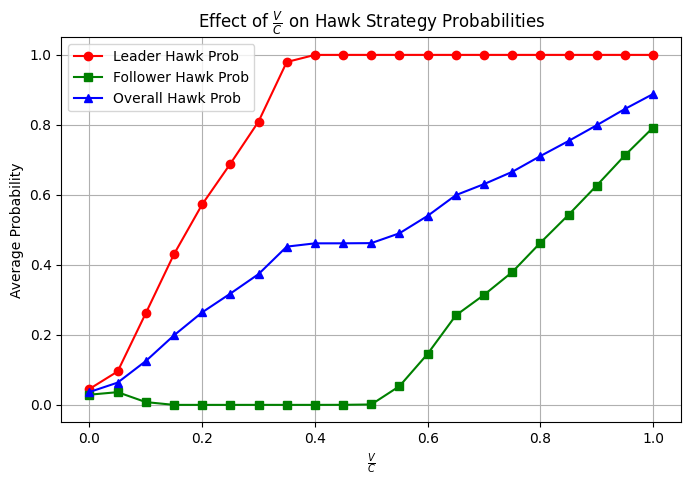

In [ ]:
# Define range of V values
V_values = np.arange(0, 2.1, 0.1)

# Store average probabilities
leader_hawk_avg = []
follower_hawk_avg = []
hawk_avg = []

for V in V_values:
    print(f"Running model for V = {V:.2f}")
    # Initialize and run the model for the given V
    model = GroupModel(
                N=N,
                num_groups=num_groups,
                omega=omega,
                dv=dv,
                dc=dc,
                V=V,
                C=C,
                time_steps=5000
            )
    # Run the model
    for k in range(model.time_steps):
        if (k + 1) % 1000 == 0:
            print(f"Step {k+1}")
        model.step()

    # Extract final 100 probability values
    final_values = model.get_final_prob_values()

    # Compute averages
    leader_hawk_avg.append(np.mean(final_values["leader_hawk_prob_values"]))
    follower_hawk_avg.append(np.mean(final_values["follower_hawk_prob_values"]))
    hawk_avg.append(np.mean(final_values["hawk_prob_values"]))

    V_valuesbar = V_values / C

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(V_valuesbar, leader_hawk_avg, label="Leader Hawk Prob", color='red')
plt.plot(V_valuesbar, follower_hawk_avg, label="Follower Hawk Prob", color='green')
plt.plot(V_valuesbar, hawk_avg, label="Overall Hawk Prob", color='blue')

plt.xlabel(r"$\frac{V}{C}$")
plt.ylabel("Average Probability")
plt.title(r"Effect of $\frac{V}{C}$ on Hawk Strategy Probabilities")
plt.legend()
plt.grid()
plt.show()


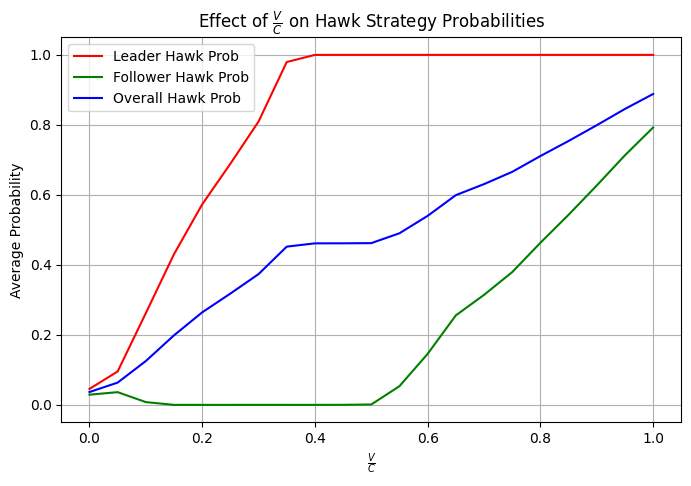

In [ ]:
# Plot results
plt.figure(figsize=(8, 5))
plt.plot(V_valuesbar, leader_hawk_avg, label="Leader Hawk Prob", color='red')
plt.plot(V_valuesbar, follower_hawk_avg, label="Follower Hawk Prob", color='green')
plt.plot(V_valuesbar, hawk_avg, label="Overall Hawk Prob", color='blue')

plt.xlabel(r"$\frac{V}{C}$")
plt.ylabel("Average Probability")
plt.title(r"Effect of $\frac{V}{C}$ on Hawk Strategy Probabilities")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Define range of V values
omega_values = np.arange(0.05, 1.05, 0.05)

# Store average probabilities
leader_hawk_avg = []
follower_hawk_avg = []
hawk_avg = []

for omega in omega_values:
    print(f"Running model for omega = {omega:.2f}")
    # Initialize and run the model for the given V
    model = GroupModel(
                N=N,
                num_groups=num_groups,
                omega=omega,
                dv=dv,
                dc=dc,
                V=V,
                C=C,
                time_steps=1000
            )
    # Run the model
    for j in range(model.time_steps):
        if (j + 1) % 100 == 0:
            print(f"Step {j+1}")
        model.step()

    # Extract final 100 probability values
    final_values = model.get_final_prob_values()

    # Compute averages
    leader_hawk_avg.append(np.mean(final_values["leader_hawk_prob_values"]))
    follower_hawk_avg.append(np.mean(final_values["follower_hawk_prob_values"]))
    hawk_avg.append(np.mean(final_values["hawk_prob_values"]))

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(omega_values, leader_hawk_avg, label="Leader Hawk Prob", marker="o")
plt.plot(omega_values, follower_hawk_avg, label="Follower Hawk Prob", marker="s")
plt.plot(omega_values, hawk_avg, label="Overall Hawk Prob", marker="^")

plt.xlabel("Omega (Shared Decision making)")
plt.ylabel("Average Probability")
plt.title(rf"Effect of $\Omega$ on Hawk Strategy Probabilities")
plt.legend()
plt.grid()
plt.show()

Running model for omega = 0.05


<ipython-input-20-1f2fc92bda4a>:201: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = SimultaneousActivation(self)
/usr/local/lib/python3.11/dist-packages/mesa/agent.py:69: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900
Step 1000
Running model for omega = 0.10
Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900
Step 1000
Running model for omega = 0.15
Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900
Step 1000
Running model for omega = 0.20
Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900
Step 1000
Running model for omega = 0.25
Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900
Step 1000
Running model for omega = 0.30
Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900
Step 1000
Running model for omega = 0.35
Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900
Step 1000
Running model for omega = 0.40
Step 100
Step 200
Step 300
Step 400
Step 500
Step 600


KeyboardInterrupt: 

In [ ]:
# Define range of V values
omega_values = np.arange(0.05, 1.05, 0.05)

# Store average probabilities
leader_hawk_avg = []
follower_hawk_avg = []
hawk_avg = []

for omega in omega_values:
    print(f"Running model for omega = {omega:.2f}")
    # Initialize and run the model for the given V
    model = GroupModel(
                N=N,
                num_groups=num_groups,
                omega=omega,
                dv=dv,
                dc=dc,
                V=V,
                C=C,
                time_steps=500
            )
    # Run the model
    for j in range(model.time_steps):
        if (j + 1) % 100 == 0:
            print(f"Step {j+1}")
        model.step()

    # Extract final 100 probability values
    final_values = model.get_final_prob_values()

    # Compute averages
    leader_hawk_avg.append(np.mean(final_values["leader_hawk_prob_values"]))
    follower_hawk_avg.append(np.mean(final_values["follower_hawk_prob_values"]))
    hawk_avg.append(np.mean(final_values["hawk_prob_values"]))

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(omega_values, leader_hawk_avg, label="Leader Hawk Prob", marker="o")
plt.plot(omega_values, follower_hawk_avg, label="Follower Hawk Prob", marker="s")
plt.plot(omega_values, hawk_avg, label="Overall Hawk Prob", marker="^")

plt.xlabel("Omega (Shared Decision making)")
plt.ylabel("Average Probability")
plt.title(rf"Effect of $\Omega$ on Hawk Strategy Probabilities")
plt.legend()
plt.grid()
plt.show()